In [1]:
#decay rate 0.01 500 step 
decay_steps=100
deacy_rate=0.001

In [2]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
#cuda and cpu require diffrenet variables !!!!!!!!!!! 

In [5]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

#expanding and the concatenating
#Concatenation refers to joining. This function is used to join two or more arrays of the same shape along a specified axis
#This function expands the array by inserting a new axis at the specified position. Two parameters are required by this function. 

In [6]:
'''
#!git clone https://github.com/openai/baselines.git
#cd baselines
#pip install -e .
!git clone https://github.com/openai/atari-py
!wget http://www.atarimania.com/roms/Roms.rar
!unrar x Roms.rar .
!python -m atari_py.import_roms
'''
'''
!pip install gym-super-mario-bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
'''

'\n!pip install gym-super-mario-bros\nfrom nes_py.wrappers import JoypadSpace\nimport gym_super_mario_bros\nfrom gym_super_mario_bros.actions import SIMPLE_MOVEMENT\n'

In [7]:
'''
env =  gym_super_mario_bros.make('SuperMarioBros-v0')
env=JoypadSpace(env, SIMPLE_MOVEMENT)
'''

"\nenv =  gym_super_mario_bros.make('SuperMarioBros-v0')\nenv=JoypadSpace(env, SIMPLE_MOVEMENT)\n"

In [8]:
env_id = "CartPole-v0"
#env_id="Acrobot-v1"
#env_id="MountainCar-v0"
#env_id="Pendulum-v0"
#env_id="Breakout-ram-v0"
#env_id="Breakout-v0"
#env_id=""
env = gym.make(env_id)

In [9]:
state_shape=env.observation_space.shape[0]
action_space= env.action_space.n

In [10]:
print(state_shape)
print(action_space)
print(env.observation_space)

4
2
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [11]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 5000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

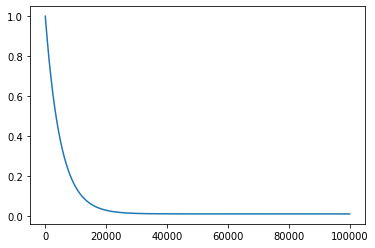

In [12]:
plt.plot([epsilon_by_frame(i) for i in range(100000)])

In [13]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        #print("ACTTT ")
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
            action=action.item()

            #print("state=:",state,"q_value=",q_value,"action=",action)

            #print("action from above")
        else:
            action = random.randrange(env.action_space.n)
            #print("action from below")
        return action

In [14]:
model = DQN(env.observation_space.shape[0], env.action_space.n)
if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=deacy_rate)
replay_buffer = ReplayBuffer(1000)

In [15]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    return loss

In [16]:

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

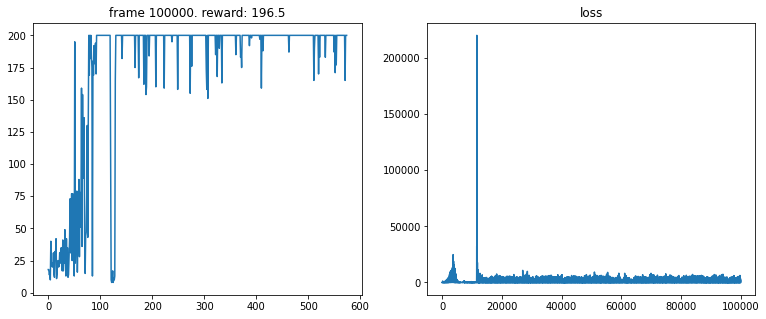

In [18]:
num_frames = 100000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    #print(action)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        #print(loss.item())
        #losses.append(loss.data[0])
        losses.append(loss.item())

    if frame_idx>12000:
      scheduler.step()

        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)